In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import seaborn as sns
import importlib
# from tqdm import tqdm
import setglobals as gl

fingers = [0, 1, 2, 3, 4]
iti = 500
total_sub_num = 16

announcement_freq = 5
n_trials_per_block = 20
n_trials_per_day = 400
n_blocks_per_day = 20
n_days = 3




In [ ]:
# Make all trial file
subjs_list = utils.read_dat_files_subjs_list(range(1,total_sub_num+1))
subjs = pd.concat(subjs_list)
utils.add_seq_pressed(subjs)
subjs = utils.remove_no_go_trials(subjs)
subjs = utils.select_training_trials(subjs)
subjs.reset_index(drop=True, inplace=True)
utils.add_IPI(subjs)
subjs['ET'] = subjs['MT'] + subjs['IPI0']
# subjs = subjs.drop_duplicates(subset=['SubNum', 'BN', 'TN'], keep='first')
# AMIN: DISCUSS - this is sloppy 
# A=pd.pivot_table(subjs, index=['SubNum', 'day','BN'], columns='TN', values='MT', aggfunc='count')
subjs.to_csv(gl.result_dir + 'SL3_all_trial_data.tsv',sep='\t', index=False)


In [39]:

subjs_presses = utils.finger_melt(subjs)
subjs_presses.to_csv('gl.result_dir + SL3_all_presses.tsv',sep='\t', index=False)

In [40]:
rank_df = pd.DataFrame(index = subjs.index, dtype='int')
for subnum, data in subjs.groupby('SubNum'):
    data = data.sort_values(by = ['BN', 'TN'])
    data['Rank'] = data.groupby(['BN', 'TN']).ngroup() + 1
    rank_df.loc[data.index, 'Rank'] = data['Rank'].astype('int')


subjs['Rank'] = rank_df['Rank'].astype('int')



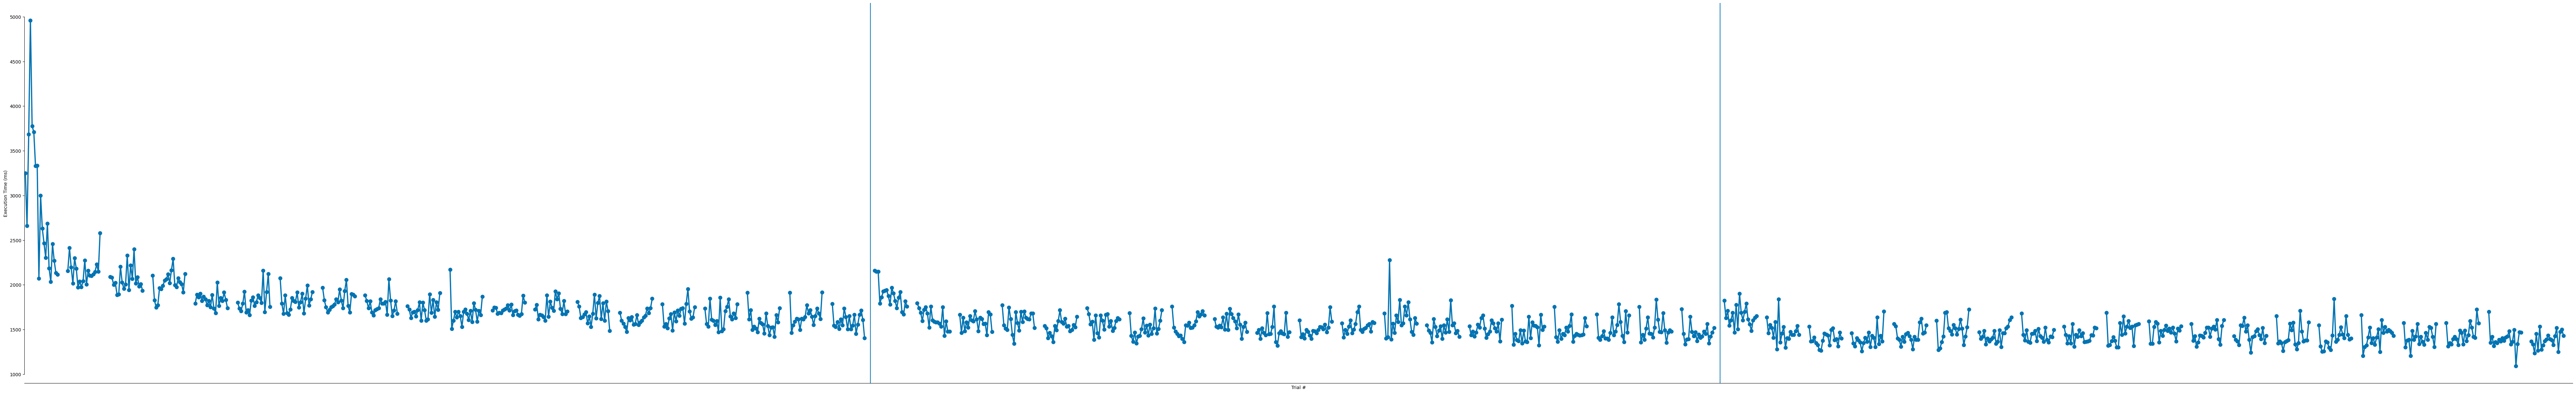

In [41]:
# plotting average Execution Time (ET) per trial # across all subjects
sns.set_palette('colorblind')
plt.figure(figsize=(100, 15))

subjs_correct = utils.remove_error_trials(subjs)

# change to desired number of trials
max_rank_to_plot = 1200

gap_x_values = []
gap_y_values = []
gap = 5
offset = gap

for idx, rank in enumerate(range(1, max_rank_to_plot, n_trials_per_block)):
    data = subjs_correct[(subjs_correct['Rank'] >= rank) & (subjs_correct['Rank'] < rank + n_trials_per_block)]
    data = data.copy()
    data['Rank'] = data['Rank'] + idx * gap
    sns.pointplot(x='Rank', y='ET', data=data, color = sns.color_palette()[0], errorbar = None)

    # insert blank gap between blocks artificial
    gap_x_values = np.array(range(rank, rank + n_trials_per_block)) + offset
    gap_y_values = [np.nan] * len(np.array(range(rank, rank + n_trials_per_block)))

    offset += gap

    sns.pointplot(x = gap_x_values, y = gap_y_values, color = 'black')

    # between days lines
    if idx == n_blocks_per_day - 1:
        plt.axvline(x = data['Rank'].max() + gap/2)

    if idx == 2 * n_blocks_per_day - 1:
        plt.axvline(x = data['Rank'].max() + gap/2)


plt.xticks(rotation=45, ticks=[])
sns.despine(trim = True)
plt.ylabel('Execution Time (ms)')
plt.xlabel('Trial #')
# plt.savefig(path_figs + 'ET_per_trial.pdf', bbox_inches='tight')
plt.show()


In [42]:
# exclude first 2 blocks within each day
first_blocks_days = list(range(7, 67, n_blocks_per_day))
print(first_blocks_days)
second_blocks_days = list(range(8, 68, n_blocks_per_day))
print(second_blocks_days)

[7, 27, 47]
[8, 28, 48]


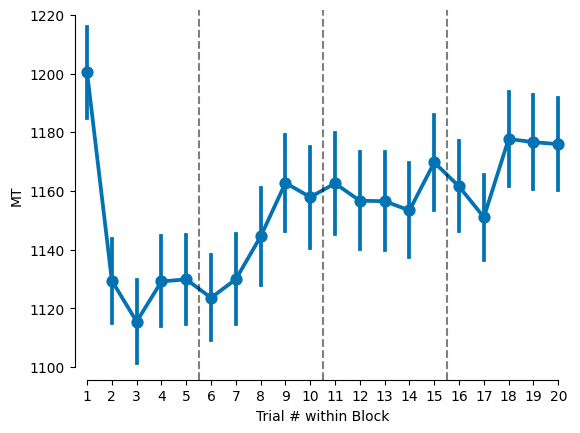

In [54]:
# plotting average Execution Time (ET) per trial # within blocks
sns.set_palette('colorblind')
# plt.figure(figsize=(100, 15))

subjs_correct = utils.remove_error_trials(subjs)

# exclude first 2 blocks within each day
subjs_correct = subjs_correct[~subjs_correct['BN'].isin(first_blocks_days)]
subjs_correct = subjs_correct[~subjs_correct['BN'].isin(second_blocks_days)]


sns.pointplot(x = 'TN', y = 'MT', data = subjs_correct, color = sns.color_palette()[0], errorbar = 'se')
plt.xticks(ticks = range(n_trials_per_block), labels = range(1, n_trials_per_block + 1))

for announcement_idx in range(announcement_freq,n_trials_per_block, announcement_freq):
    plt.axvline(x = announcement_idx - 0.5, color='black', linestyle='--', alpha = 0.5)

plt.xlabel('Trial # within Block')
sns.despine(trim= True)

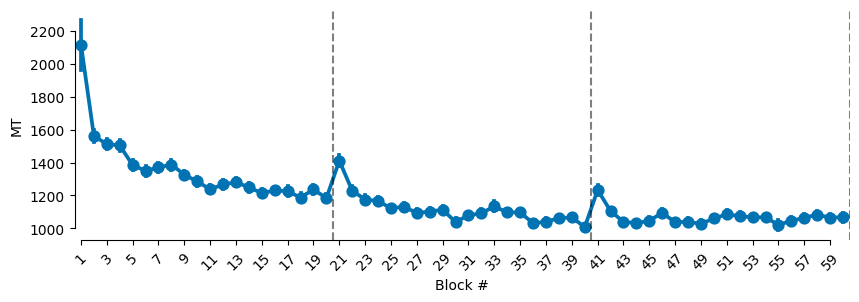

In [57]:
# plotting average Execution Time (ET) per BN
sns.set_palette('colorblind')
plt.figure(figsize=(10, 3))

subjs_correct = utils.remove_error_trials(subjs)



sns.pointplot(x = 'BN', y = 'MT', data = subjs_correct, color = sns.color_palette()[0], errorbar = 'se')
plt.xticks(ticks = range(0, (n_blocks_per_day) * n_days, 2), labels = range(1, (n_blocks_per_day) * n_days + 1, 2), rotation = 45)

for day_change_idx in [(n_blocks_per_day) * (i+1) for i in range(n_days)]:
    plt.axvline(x = day_change_idx - 0.5, color='black', linestyle='--', alpha = 0.5)

plt.xlabel('Block #')
sns.despine(trim= True)